In [2]:
# ejemplo de RNN para predecir precio de bitcoin

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten, SimpleRNN

# en jupyter lab online cargamos con tensorflow
#import tensorflow as tf
#from tensorflow.keras import Sequential
#from tensorflow.keras.layers import Dense, LSTM, Dropout,Flatten, SimpleRNN

In [4]:
# carga de datos
#data = pd.read_csv("data_bitcoin.csv") # son app 63Kb de datos.
#data.head()


# carga de datos
# vamos a importar los datos directamente desde github:
url = 'https://raw.githubusercontent.com/MAValle/deepLearning_intro_course/main/data_bitcoin.csv'
data = pd.read_csv(url)
data.head()



,Price
0,5.874167
1,5.582143
2,5.120000
3,4.835000
4,4.870000


In [5]:
data.shape

(3448, 1)

In [6]:
# El objetivo es hacer una prediccion de los precios diarios de cierre.
# consideraremos los últimos 60 precios para el testeo.

close_train = data.iloc[:len(data)-60]
close_test  = data.iloc[len(close_train):]

print(close_test.head())
print(close_train.shape)
print(close_test.shape)

             Price
3388  34793.749638
3389  34694.376658
3390  38636.764980
3391  37039.937682
3392  36841.820185
(3388, 1)
(60, 1)


In [7]:
# Aqui transformamos los valores entre 0-1 para estandarizar.

# convertir a array
close_train = np.array(close_train)
close_train = close_train.reshape(close_train.shape[0],1) # convierte close_train en un array de 3388 filas y 1 columna
print(close_train)
#print(close_train.shape[0])

[[5.87416667e+00]
 [5.58214286e+00]
 [5.12000000e+00]
 ...
 [4.04054990e+04]
 [3.89682115e+04]
 [3.36545416e+04]]


In [8]:
# estandarizar
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
close_scaled = scaler.fit_transform(close_train)
print(close_scaled)

[[8.99473645e-05]
 [8.27196354e-05]
 [7.12813785e-05]
 ...
 [1.00000000e+00]
 [9.64426445e-01]
 [8.32910571e-01]]


In [9]:
# utiliza 60 datos como set de entrenamiento y entrada, y luego la 61 es el valor a predecir.

timestep=60
x_train=[]
y_train=[]

#close_scaled.shape[0]  es el largo de la serie igual a 3388

for i in range(timestep,close_scaled.shape[0]):
    x_train.append(close_scaled[i-timestep:i,0])
    y_train.append(close_scaled[i,0])


#print(x_train) # tiene 3388 vectores de 60 precios
print(len(x_train))
#print(y_train) # tiene 3388 precios
print(len(y_train))

#y_train[0]
x_train[0]

3328
3328


array([8.99473645e-05, 8.27196354e-05, 7.12813785e-05, 6.42274921e-05,
       6.50937588e-05, 6.43512445e-05, 6.58362732e-05, 7.84153400e-05,
       8.62801686e-05, 8.54881533e-05, 8.58841609e-05, 8.62200603e-05,
       9.42993236e-05, 9.07217545e-05, 6.52175112e-05, 6.50584010e-05,
       6.37737333e-05, 6.45574985e-05, 6.54959541e-05, 7.27994079e-05,
       6.61368147e-05, 6.02497366e-05, 5.43273006e-05, 4.08382898e-05,
       5.10354870e-05, 4.41177282e-05, 4.22738175e-05, 4.23480690e-05,
       4.47983664e-05, 4.15808041e-05, 3.96007658e-07, 0.00000000e+00,
       1.76965922e-05, 1.12202170e-05, 1.31177537e-05, 4.25089471e-05,
       4.50046203e-05, 3.20271194e-05, 2.57758556e-05, 2.68542693e-05,
       2.72930278e-05, 2.15329164e-05, 1.75728398e-05, 2.07904021e-05,
       2.43049700e-05, 2.45339120e-05, 2.62355074e-05, 2.74730313e-05,
       2.74730313e-05, 1.08572100e-05, 1.55928015e-05, 1.27464965e-05,
       1.25608679e-05, 8.22953415e-06, 5.50698150e-06, 3.21756222e-06,
      

In [10]:
# paso 2
x_train,y_train = np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) #reshaped for RNN
print("x-train-shape= ",x_train.shape)
print("y-train-shape= ",y_train.shape)

x-train-shape=  (3328, 60, 1)
y-train-shape=  (3328,)


In [11]:
# notar la estructura de x_train:

# por ejemplo x_train.shape[1] es un array con 60 columnas. Estas columnas son las
#que van a entrar al input layer. No entra un vector numérico.
# esto es importante porque condiciona la forma en que salen los ouputs.

print(x_train.shape) # tenemos 3328 vectores de 60 precios. Esto es lo que va entrando a la red.
print(x_train.shape[1]) # cada vector tiene 60 precios.


(3328, 60, 1)
60


In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

In [13]:
# Implementacion de NN
# la API de Keras Sequential es usada como de costumbre para crear el modelo. El MLP se contruye
# sobre la base de capas en lostes densamente conectadas, por lo que usamos la funcion Dense().

# Luego la arquitectura se compila estableciendo los hiperparámetros y el kernel de optimización.
# Finalmente, se fitea la red a los datos de entrenamiento con 50 epochs.

model = Sequential()
model.add(Dense(56, input_shape=(x_train.shape[1],1), activation='relu')) # entrada 60 neuronas, salida 56 neuronas
#model.add(Dense(56, input_shape=(x_train.shape[1],), activation='relu')) # entrada 60 neuronas, salida 56 neuronas
model.add(Dense(32, activation='relu'))
model.add(Flatten())  #https://stackoverflow.com/questions/43237124/what-is-the-role-of-flatten-in-keras
model.add(Dense(1))

model.compile(optimizer="adam",loss="mean_squared_error", metrics=['mse'])
history = model.fit(x_train,y_train,epochs=10,batch_size=64)


Epoch 1/10
52/52 [==============================] - 1s 6ms/step - loss: 0.0030 - mse: 0.0030
Epoch 2/10
52/52 [==============================] - 0s 6ms/step - loss: 7.8870e-04 - mse: 7.8870e-04
Epoch 3/10
52/52 [==============================] - 0s 6ms/step - loss: 5.0208e-04 - mse: 5.0208e-04
Epoch 4/10
52/52 [==============================] - 0s 5ms/step - loss: 3.3882e-04 - mse: 3.3882e-04
Epoch 5/10
52/52 [==============================] - 0s 6ms/step - loss: 2.7058e-04 - mse: 2.7058e-04
Epoch 6/10
52/52 [==============================] - 0s 5ms/step - loss: 2.2948e-04 - mse: 2.2948e-04
Epoch 7/10
52/52 [==============================] - 0s 6ms/step - loss: 1.9034e-04 - mse: 1.9034e-04
Epoch 8/10
52/52 [==============================] - 0s 5ms/step - loss: 1.6692e-04 - mse: 1.6692e-04
Epoch 9/10
52/52 [==============================] - 0s 5ms/step - loss: 1.5717e-04 - mse: 1.5717e-04
Epoch 10/10
52/52 [==============================] - 0s 5ms/step - loss: 1.6832e-04 - mse: 1.6832e-

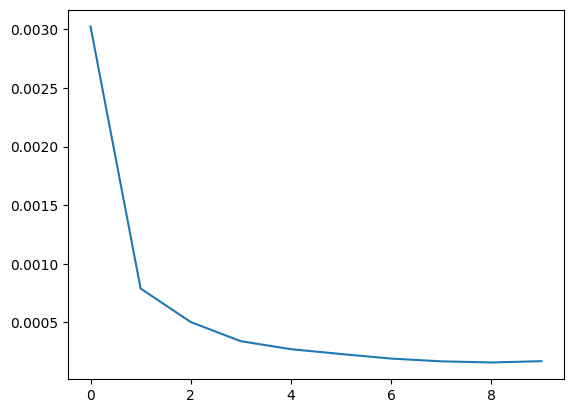

In [14]:
# Evaluacion del modelo con train set
#print(history.history) # tiene loss y mean_squared_error

plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['mean_squared_error'], label='train')
plt.show()

In [15]:
# ahora preparamos data de test para prediccion.
# recordemos que en close_test tenemos nuestros datos para el testeo!

# len(data) - len(close_test)# = 3388  datos de entrenamiento
# len(data) - len(close_test) - timestep = 3328. tomaremos para prediccion desde el dato 3328
# hasta el ultimo quedando en 120 valores. Tomamos 60 de entrenamiento y otros 60 del test.
# Esto lo dejaremos en input.
# ¿por que?  porque si queremos 60 predicciones con 60 datos de entrada, necesitamos al menos
# el doble de datos.

inputs=data[len(data)-len(close_test)-timestep:]


inputs=inputs.values.reshape(-1,1) # convierte inputs a array de 120 filas y 1 columna
print(inputs.shape)
print(inputs)
inputs=scaler.transform(inputs) # escala valores 0-1.



(120, 1)
[[16279.82971834]
 [16002.77983225]
 [15979.96787722]
 [16430.74588307]
 [17268.94039002]
 [17881.21028309]
 [17801.6469543 ]
 [18360.23015132]
 [18720.46861578]
 [18337.80238069]
 [18438.878714  ]
 [18939.28873823]
 [19051.71350101]
 [17200.67461348]
 [16955.0982882 ]
 [17389.9772657 ]
 [18027.70585954]
 [19061.8357438 ]
 [19196.46453403]
 [18933.50034101]
 [19309.47116477]
 [19081.52631458]
 [18981.5437042 ]
 [19150.4708231 ]
 [19189.08096393]
 [18865.08550867]
 [18244.81628606]
 [18273.61070645]
 [17923.9118587 ]
 [18479.16546148]
 [19142.26171027]
 [19166.1507658 ]
 [19335.52610827]
 [20378.55465055]
 [22730.73493971]
 [22865.0388434 ]
 [23458.76198432]
 [23603.69759416]
 [23078.46686784]
 [23129.09807163]
 [23483.56654105]
 [23203.45488959]
 [24075.884614  ]
 [25594.26362466]
 [27094.35316904]
 [26963.03143607]
 [26654.23907847]
 [28180.26608524]
 [28835.9243266 ]
 [29269.12533855]
 [31247.50621825]
 [33477.30571855]
 [31286.55592198]
 [32372.35450507]
 [34957.00203889]
 

In [16]:
# paso 2
# al igual que con x_train, tenemos que generar del set de datos de input, aquellas muestras
# que seran de entrada para hacer la prediccion. Obviamente, en bloques de 60.


x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

print(x_test.shape) #60 vectores con 60 valores de entrada para la prediccion.
print(x_test)

(60, 60, 1)
[[[0.40287814]
  [0.39602102]
  [0.39545641]
  ...
  [1.        ]
  [0.96442644]
  [0.83291057]]

 [[0.39602102]
  [0.39545641]
  [0.40661338]
  ...
  [0.96442644]
  [0.83291057]
  [0.86110652]]

 [[0.39545641]
  [0.40661338]
  [0.4273591 ]
  ...
  [0.83291057]
  [0.86110652]
  [0.85864699]]

 ...

 [[1.        ]
  [0.96442644]
  [0.83291057]
  ...
  [1.24625283]
  [1.25827194]
  [1.33648419]]

 [[0.96442644]
  [0.83291057]
  [0.86110652]
  ...
  [1.25827194]
  [1.33648419]
  [1.37531074]]

 [[0.83291057]
  [0.86110652]
  [0.85864699]
  ...
  [1.33648419]
  [1.37531074]
  [1.39307122]]]


In [17]:
#predicciones

predicted_data=model.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

print(predicted_data)

2/2 [==============================] - 1s 12ms/step
[[39999.52 ]
 [40146.15 ]
 [40208.188]
 [40974.22 ]
 [41732.797]
 [42091.59 ]
 [42384.07 ]
 [42472.754]
 [42586.152]
 [41815.8  ]
 [40662.355]
 [39911.652]
 [39552.938]
 [39648.35 ]
 [39289.96 ]
 [39006.387]
 [38077.56 ]
 [37992.94 ]
 [38330.387]
 [38325.473]
 [38189.812]
 [38053.195]
 [38099.035]
 [38356.137]
 [38922.81 ]
 [39826.914]
 [41054.164]
 [42017.535]
 [42986.04 ]
 [44465.504]
 [45760.133]
 [47115.21 ]
 [48559.754]
 [49900.77 ]
 [51554.293]
 [52543.29 ]
 [53808.082]
 [55337.215]
 [57308.87 ]
 [58367.83 ]
 [60312.883]
 [62191.09 ]
 [62355.41 ]
 [61868.223]
 [61984.14 ]
 [62044.254]
 [61738.453]
 [61154.71 ]
 [60940.07 ]
 [60831.57 ]
 [60723.63 ]
 [60562.984]
 [60089.434]
 [59603.363]
 [59758.094]
 [60095.117]
 [59578.27 ]
 [60178.59 ]
 [61162.742]
 [63063.99 ]]


In [ ]:
# para ploteo
data_test = np.array(close_test)
data_test = data_test.reshape(len(data_test),1)

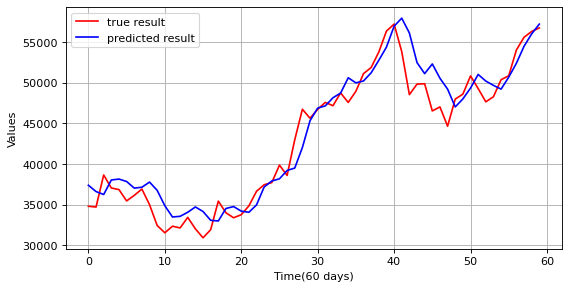

In [ ]:
# ploteo de predicciones
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(60 days)")
plt.ylabel("Values")
plt.grid(True)
plt.show()


In [ ]:
# Como hacemos para ver la evolucion del MSE (loss function) con el set de test?

#print(data_test.shape)  # (60, 1)
#print(predicted_data.shape) # (60, 1)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(data_test, predicted_data)

print(mse)


5378022.8198098


In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
print(x_train.shape)
print(x_train.shape[1])

(3328, 60, 1)
60


In [19]:
# Implementacion de RNN

# Tenemos en Keras el layer “SimpleRNN”, que tiene como entrada un tensor de shape
#(batch_size, internal_units) y sus repsectivas funciones de activación (RELU).
# La RNN pasa informacion a traves de la capa escondida a la siguiente capa y a si misma, por lo que
# dejamos return_sequences = True.
# La matriz al final es convertida en un solo vector de 1 columna usando Flatten().
# finalmente compilamos.

reg=Sequential()
reg.add(SimpleRNN(128,activation="relu", return_sequences = True, input_shape=(x_train.shape[1],1)))
#reg.add(Dropout(0.25))
#aqui el shape de salida de esta capa seria (1,60,128), es decir 60 vectores con 128 estados de las neuronas
# que van de input a la siguiente capa. La última (output del timestamp 60) se realimenta a primera RNN
# de esta capa.

reg.add(SimpleRNN(256,activation="relu",return_sequences = True))
#reg.add(Dropout(0.25))

reg.add(SimpleRNN(512,activation="relu",return_sequences = True))
#reg.add(Dropout(0.35))

reg.add(Flatten())
reg.add(Dense(1))

reg.compile(optimizer="adam",loss="mean_squared_error")
history = reg.fit(x_train,y_train,epochs=5,batch_size=64)

Epoch 1/5
52/52 [==============================] - 25s 417ms/step - loss: 0.0016
Epoch 2/5
52/52 [==============================] - 22s 424ms/step - loss: 3.4229e-04
Epoch 3/5
52/52 [==============================] - 21s 391ms/step - loss: 2.0657e-04
Epoch 4/5
52/52 [==============================] - 22s 416ms/step - loss: 1.9929e-04
Epoch 5/5
52/52 [==============================] - 20s 381ms/step - loss: 2.0211e-04


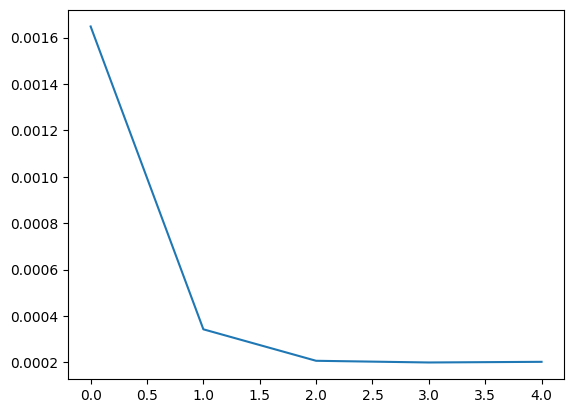

In [20]:
# #evaluacion del proceso

plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['mean_squared_error'], label='train')
plt.show()


In [ ]:
# predicciones.

predicted_data=reg.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

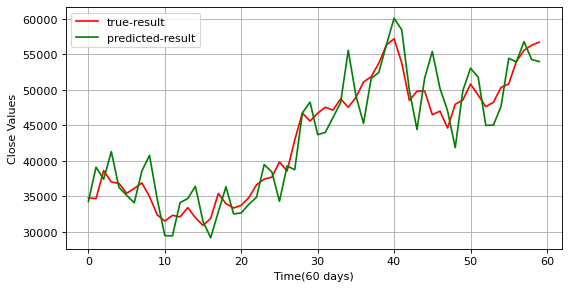

In [ ]:
# Ploteo.
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true-result")
plt.plot(predicted_data,color="g",label="predicted-result")
plt.legend()
plt.xlabel("Time(60 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

In [ ]:
# Como hacemos para ver la evolucion del MSE (loss function) con el set de test?

#print(data_test.shape)  # (60, 1)
#print(predicted_data.shape) # (60, 1)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(data_test, predicted_data)

print(mse)

9878539.711630173


In [ ]:
# Los resultados no son tan satisfactorios. esto es debido al vanishing gradient.
# Podemos utilizar LSTM
